# Torch-KWT Tutorial

This notebook will guide you through the steps to training and running inference on Google Speech Commands V2 (35) with the [Torch-KWT](https://github.com/ID56/Torch-KWT) repository.

## Setup

### 1. Clone the repository

In [ ]:
!git clone https://github.com/ID56/Torch-KWT.git

Cloning into 'Torch-KWT'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 99 (delta 41), reused 67 (delta 19), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [ ]:
cd Torch-KWT/

/content/Torch-KWT


### 2. Install requirements

In [ ]:
!pip install -qr requirements.txt

     |████████████████████████████████| 636 kB 5.2 MB/s 
     |████████████████████████████████| 1.7 MB 40.9 MB/s 
     |████████████████████████████████| 133 kB 52.5 MB/s 
     |████████████████████████████████| 170 kB 45.2 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


### 3. Download the Google Speech Commands V2 dataset

We'll be saving it to the `./data/` folder.

In [ ]:
!sh ./download_gspeech_v2.sh ./data/

--2021-08-28 16:09:35--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.152.128, 2607:f8b0:4001:c56::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.152.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘STDOUT’

-                   100%[===================>]   2.26G  33.0MB/s    in 57s     

2021-08-28 16:10:32 (40.8 MB/s) - written to stdout [2428923189/2428923189]



In [ ]:
!ls data

_background_noise_  five     left     README.md		tree
backward	    follow   LICENSE  right		two
bed		    forward  marvin   seven		up
bird		    four     nine     sheila		validation_list.txt
cat		    go	     no       six		visual
dog		    happy    off      stop		wow
down		    house    on       testing_list.txt	yes
eight		    learn    one      three		zero


As you can see, the dataset provides a `validation_list.txt` and a `testing_list.txt` as the split. We'll run a simple script `make_data_list.py` to also generate a `training_list.txt`, as well as a `label_map.json` that maps numeric indices to class labels.

In [ ]:
!python make_data_list.py -v ./data/validation_list.txt -t ./data/testing_list.txt -d ./data/ -o ./data/

Number of training samples: 84843
Number of validation samples: 9981
Number of test samples: 11005
Saved data lists and label map.


## Using Pre-trained Models for Inference

The Torch-KWT repository provides a single checkpoint for KWT-1 at present, which has a 95.98 % accuracy on the test set. We can use this checkpoint to run some inferences, before we look at training.

### 4. Downloading Pre-Trained Model

In [1]:
!wget -O "kwt1_pretrained.ckpt" "https://drive.google.com/uc?id=1y91PsZrnBXlmVmcDi26lDnpl4PoC5tXi&export=download"

--2022-10-11 13:32:43--  https://drive.google.com/uc?id=1y91PsZrnBXlmVmcDi26lDnpl4PoC5tXi&export=download
Resolving drive.google.com (drive.google.com)... 142.251.18.138, 142.251.18.139, 142.251.18.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.18.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-98-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7h9sl492h6igcnoc8k0ik6hjl9epi3ls/1665495150000/08205965344461127957/*/1y91PsZrnBXlmVmcDi26lDnpl4PoC5tXi?e=download&uuid=a89a1268-5329-41b0-ac0f-bb06af2f60af [following]
--2022-10-11 13:32:45--  https://doc-0o-98-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7h9sl492h6igcnoc8k0ik6hjl9epi3ls/1665495150000/08205965344461127957/*/1y91PsZrnBXlmVmcDi26lDnpl4PoC5tXi?e=download&uuid=a89a1268-5329-41b0-ac0f-bb06af2f60af
Resolving doc-0o-98-docs.googleusercontent.com (doc-0o-98-docs.googleusercontent.com)... 142.251.31.132, 2a00:

### 5. Exploring Some Test Set Audio Files

Let's take a few files from the test set, take a look at their melspectrograms, and listen to them.

In [ ]:
!cat data/testing_list.txt | head -n 3

./data/six/8fe67225_nohash_4.wav
./data/one/ca4d5368_nohash_2.wav
./data/seven/2d82a556_nohash_0.wav


In [ ]:
from IPython.display import Audio
import matplotlib.pyplot as plt
import librosa

samples = [
    "./data/visual/3d86b69a_nohash_0.wav",
    "./data/dog/881583a6_nohash_0.wav",
    "./data/zero/4fd1443e_nohash_2.wav"
]

def show_melspec(audio_path):
    print(f"Showing {audio_path}")
    audio_settings = {
        "sr": 16000,
        "n_mels": 40,
        "n_fft": 480,
        "win_length": 480,
        "hop_length": 160,
        "center": False
    }
    x = librosa.load(audio_path, audio_settings["sr"])[0]
    x = librosa.util.fix_length(x, audio_settings["sr"])
    x = librosa.feature.melspectrogram(y=x, **audio_settings)      
  
    plt.figure(figsize=(7, 5))
    plt.imshow(x, cmap="hot")
    plt.show()



Showing ./data/visual/3d86b69a_nohash_0.wav


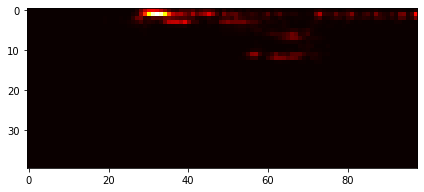

In [ ]:
show_melspec(samples[0])
Audio(samples[0])

Showing ./data/dog/881583a6_nohash_0.wav


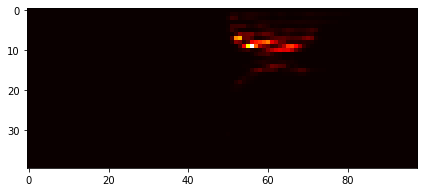

In [ ]:
show_melspec(samples[1])
Audio(samples[1])

Showing ./data/zero/4fd1443e_nohash_2.wav


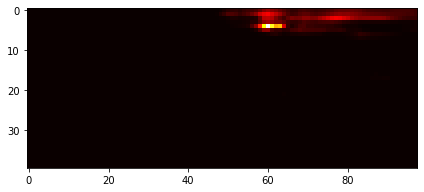

In [ ]:
show_melspec(samples[2])
Audio(samples[2])

### 6. Using Inference Scipts

There are two inference scripts provided in the repository:
- `inference.py`
- `window_inference.py`.

We'll be using the pretrained model we downloaded earlier to test these inference scripts.

**Using `inference.py`:**

For simple short clips that are about 1s, such as the audios in the Speech Commands dataset, you can simply use `inference.py` to get predictions. It can be run on a single audio clip, as well as a folder containing several audio clips.

Let us first try **inferencing on a single short clip**:

In [ ]:
!python inference.py --conf sample_configs/base_config.yaml \
                     --ckpt kwt1_pretrained.ckpt \
                     --inp data/dog/881583a6_nohash_0.wav \
                     --out outputs/single_preds/ \
                     --lmap label_map.json \
                     --device cpu             # you can also use cuda

100% 1/1 [00:00<00:00,  4.01it/s]
Saved preds to outputs/single_preds/preds.json


Let us check the prediction output:

In [ ]:
!cat outputs/single_preds/preds.json

{"data/dog/881583a6_nohash_0.wav": "dog"}

Seems like it's correct!

Similarly, you can also provide **a folder containing multiple audio wavs** to the `--inp` argument, instead of a single audio path. Let's take the last 3 audios in testing list and put them in a folder:

In [ ]:
# Moving multiple audios to a single folder "samples"
!cat data/testing_list.txt | tail -n 3
!mkdir -p samples/
!cp $(cat data/testing_list.txt | tail -n 3) samples/

./data/three/4a0e2c16_nohash_0.wav
./data/nine/b49caed3_nohash_0.wav
./data/right/ef2a3cfb_nohash_0.wav

In [ ]:
# Run inference
!python inference.py --conf sample_configs/base_config.yaml \
                     --ckpt kwt1_pretrained.ckpt \
                     --inp samples/ \
                     --out outputs/folder_preds/ \
                     --lmap label_map.json \
                     --device cpu

100% 3/3 [00:00<00:00, 48.76it/s]
Saved preds to outputs/folder_preds/preds.json


The outputs are in a similar json format.

In [ ]:
!cat outputs/folder_preds/preds.json

{"samples/ef2a3cfb_nohash_0.wav": "right", "samples/b49caed3_nohash_0.wav": "nine", "samples/4a0e2c16_nohash_0.wav": "three"}

*If you are running inference on a large number of clips, you can also use the **--batch_size** argument.* By default, batch size is set to 1 during inference.



---



---

**Using window_inference.py:**

In real life use-case, audios are typically much longer than 1s. To get predictions from long audios, we thus need to run multiple inferences on various "chunks" or "windows" in that audio clip.

![window.png](https://raw.githubusercontent.com/ID56/Torch-KWT/main/resources/window.png)

While we don't have a long clip here, we can try **concatenating the three wavs** inside the `samples/` folder we made above into **a single 3s long audio clip**.

In [ ]:
from IPython.display import Audio
import soundfile as sf
import numpy as np
import librosa
import glob

def concat_audio(audio_folder):
    audio_list = []
    for audio_file in glob.glob(f"{audio_folder}/*.wav"):
       x = librosa.load(audio_file, sr=16000)[0]
       x = librosa.util.fix_length(x, 16000)
       audio_list.append(x)
    long_audio = np.hstack(audio_list)
    sf.write("long_audio.wav", long_audio, 16000)

concat_audio("samples/")
Audio("long_audio.wav")

Now let's run `window_inference.py`. It can be run in three modes:

- multi: saves all found predictions (default)
- max: saves the "most confident" prediction (outputs only a single 'clipwise; prediction for the whole clip)
- n_voting: saves the "most frequent" prediction (outputs only a single 'clipwise' prediction for the whole clip)

The `multi` mode is probably the most useful, and is thus the default mode. We will run inferences over **1s windows**, and **slide the window by 0.5s**. We will only keep the predictions with **confidence over 0.85**.

In [ ]:
!python window_inference.py --conf sample_configs/base_config.yaml \
                     --ckpt kwt1_pretrained.ckpt \
                     --inp long_audio.wav \
                     --out outputs/long_audio/ \
                     --lmap label_map.json \
                     --device cpu \
                     --wlen 1 \
                     --stride 0.5 \
                     --thresh 0.85 \
                     --mode multi

Saved preds to outputs/long_audio/preds_clip.json


In [ ]:
!cat outputs/long_audio/preds_clip.json

{"long_audio.wav": [["right", 0.9044998288154602, 0.0, 16000.0], ["nine", 0.9019867777824402, 16000.0, 32000.0], ["nine", 0.9060007333755493, 24000.0, 40000.0], ["three", 0.8826960325241089, 32000.0, 48000.0]]}

- Outputs are in the form: **[class, confidence, start_sample, end_sample]**. (If you divide sample by sample rate, you can get the time range)
- It is possible that sometimes two windows may both partially fall on the same keyword instance. In such a case, you may get two consecutive predictions of the same class with some overlap. *(Like, nine-1s-2s and nine-1.5s-2.5s.)*
- Similar to `inference.py` the `--inp` argument in `window_inference.py` can also work with a folder of audio files
- You can also set the --batch_size argument for faster inference on GPU

## Training

For training, we only need to provide the config file.

### 9. Setting Up Your Config File

For this example, we'll be using the `sample_configs/base_config.yaml`. In fact, you should be able to use this config to reproduce the results of the provided pretrained KWT-1 checkpoint if you follow the exact settings (training for 140 epochs / ~23000 steps @ batch_size = 512).

We'll be training for 10 epochs in this example.

You can also use [wandb](wandb.ai) to log your runs. Either provide a path to a txt file containing your API key, or set the env variable "WANDB_API_KEY", like:

```
os.environ["WANDB_API_KEY"] = "yourkey"
```

We will not be using wandb in this example, but feel free to try it.

In [ ]:
conf_str = """# sample config to run a demo training of 20 epochs

data_root: ./data/
train_list_file: ./data/training_list.txt
val_list_file: ./data/validation_list.txt
test_list_file: ./data/testing_list.txt
label_map: ./data/label_map.json

exp:
    wandb: False
    wandb_api_key: <path/to/api/key>
    proj_name: torch-kwt-1
    exp_dir: ./runs
    exp_name: exp-0.0.1
    device: auto
    log_freq: 20    # log every l_f steps
    log_to_file: True
    log_to_stdout: True
    val_freq: 1    # validate every v_f epochs
    n_workers: 1
    pin_memory: True
    cache: 2 # 0 -> no cache | 1 -> cache wavs | 2 -> cache specs; stops wav augments
    

hparams:
    seed: 0
    batch_size: 512
    n_epochs: 10
    l_smooth: 0.1

    audio:
        sr: 16000
        n_mels: 40
        n_fft: 480
        win_length: 480
        hop_length: 160
        center: False
    
    model:
        name: # if name is provided below settings will be ignored during model creation   
        input_res: [40, 98]
        patch_res: [40, 1]
        num_classes: 35
        mlp_dim: 256
        dim: 64
        heads: 1
        depth: 12
        dropout: 0.0
        emb_dropout: 0.1
        pre_norm: False

    optimizer:
        opt_type: adamw
        opt_kwargs:
          lr: 0.001
          weight_decay: 0.1
    
    scheduler:
        n_warmup: 10
        max_epochs: 140
        scheduler_type: cosine_annealing

    augment:
        # resample:
            # r_min: 0.85
            # r_max: 1.15
        
        # time_shift:
            # s_min: -0.1
            # s_max: 0.1

        # bg_noise:
            # bg_folder: ./data/_background_noise_/

        spec_aug:
            n_time_masks: 2
            time_mask_width: 25
            n_freq_masks: 2
            freq_mask_width: 7"""

!mkdir -p configs
with open("configs/kwt1_colab.yaml", "w+") as f:
  f.write(conf_str)

### 10. Initiating Training

Make sure you are using a GPU runtime.

In order to train to a full 140 epochs / 23000 steps like the paper, on free resources, we need to cut down on disk I/O and audio processing time. So, we'll preemptively convert all our `.wav` files into MFCCs of shape `(40, 98)` and keep them stored in memory. This caching process may take ~6 minutes.

Since we'll be directly using MFCCs, no wav augmentations like resample, time_shift or background_noise will be used; we'll just use spectral augmentation with the settings from the paper.



> Note: You may notice a "Warning: Leaking Caffe2 thread-pool after fork." message after each epoch. It seems to be an existing torch-1.9 issue, which you can ignore. [See more here.](https://github.com/pytorch/pytorch/issues/57273)





In [ ]:
!python train.py --conf configs/kwt1_colab.yaml

Set seed 0
Using settings:
 data_root: ./data/
exp:
  cache: 2
  device: &id001 !!python/object/apply:torch.device
  - cuda
  exp_dir: ./runs
  exp_name: exp-0.0.1
  log_freq: 20
  log_to_file: true
  log_to_stdout: true
  n_workers: 1
  pin_memory: true
  proj_name: torch-kwt-1
  save_dir: ./runs/exp-0.0.1
  val_freq: 1
  wandb: false
  wandb_api_key: <path/to/api/key>
hparams:
  audio:
    center: false
    hop_length: 160
    n_fft: 480
    n_mels: 40
    sr: 16000
    win_length: 480
  augment:
    spec_aug:
      freq_mask_width: 7
      n_freq_masks: 2
      n_time_masks: 2
      time_mask_width: 25
  batch_size: 512
  device: *id001
  l_smooth: 0.1
  model:
    depth: 12
    dim: 64
    dropout: 0.0
    emb_dropout: 0.1
    heads: 1
    input_res:
    - 40
    - 98
    mlp_dim: 256
    name: null
    num_classes: 35
    patch_res:
    - 40
    - 1
    pre_norm: false
  n_epochs: 10
  optimizer:
    opt_kwargs:
      lr: 0.001
      weight_decay: 0.1
    opt_type: adamw
  schedul

After training 10 epochs, we have a validation accuracy of **~78.99%** and a test accuracy of **~76.52%**.

In colab, it takes ~84s per epoch, with an additional ~3s for validation. To do a complete training like the paper (140 epochs / 23K steps) on colab, you'd thus need around **3.4 hours**.

You may also try running Torch-KWT training on kaggle, which I've found to be notably faster. Full training takes less than **2 hours** there.